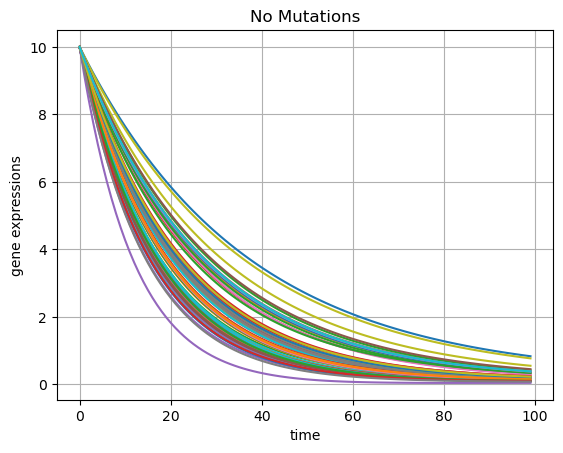

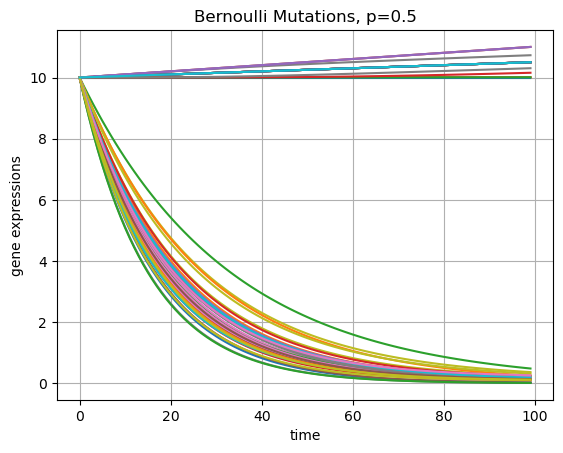

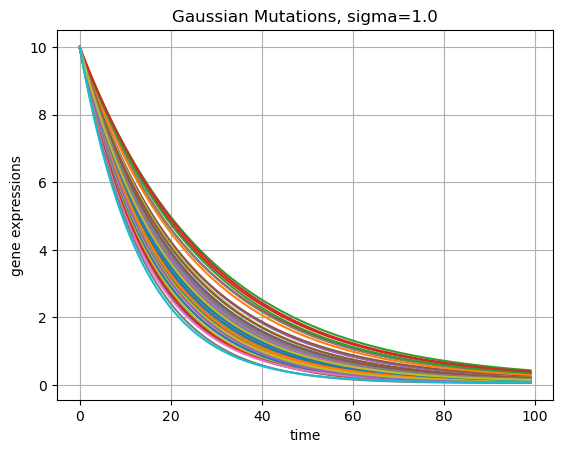

In [13]:
import pytest
import torch
import matplotlib.pyplot as plt
import numpy as np

from flecs.cell_population import TestCellPop
from flecs.mutation import apply_bernoulli_mutation, apply_gaussian_mutation
from flecs.trajectory import simulate_deterministic_trajectory
from flecs.utils import plot_trajectory, set_seed

def test_mutations(n_cells=3):
    set_seed(0)

    # Simulate trajectory
    my_cells = TestCellPop(n_cells=n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, title="No Mutations")
    plt.show()

    # Simulate trajectory with bernoulli mutation to nodes.
    my_cells = TestCellPop(n_cells=n_cells)
    p = 0.5
    apply_bernoulli_mutation(my_cells["gene"], "alpha", p=p, n_cells=n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, title="Bernoulli Mutations, p={}".format(p))
    plt.show()

    # Simulate trajectory with gaussian mutation to edges [gene - activation - gene].
    my_cells = TestCellPop(n_cells=n_cells)
    sigma = 1.0
    apply_gaussian_mutation(my_cells['gene', 'activation', 'gene'], "weights", sigma=sigma, n_cells=n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, title="Gaussian Mutations, sigma={}".format(sigma))
    plt.show()

test_mutations()